In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amazon-fine-food-reviews/hashes.txt
/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite


In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [3]:
# Step 2: Load Dataset
# Download the dataset from Kaggle: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
# Load the dataset
df = pd.read_csv('/kaggle/input/amazon-fine-food-reviews/Reviews.csv')   
print("Dataset loaded successfully!")
print(df.head())

Dataset loaded successfully!
   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of 

In [4]:
# Step 3: Data Cleaning
# Drop unnecessary columns
df = df[['ProductId', 'UserId', 'Score', 'Summary', 'Text']]

# Handle missing values
print("Missing values before cleaning:", df.isnull().sum())
df.dropna(inplace=True)
print("Missing values after cleaning:", df.isnull().sum())

# Remove duplicates
df.drop_duplicates(subset=['UserId', 'Text'], inplace=True)
print("Duplicates removed!")

Missing values before cleaning: ProductId     0
UserId        0
Score         0
Summary      27
Text          0
dtype: int64
Missing values after cleaning: ProductId    0
UserId       0
Score        0
Summary      0
Text         0
dtype: int64
Duplicates removed!


In [5]:
# Step 4: Text Preprocessing
# Convert text to lowercase
df['Text'] = df['Text'].apply(lambda x: x.lower())

# Remove special characters and numbers
df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

print("Text preprocessing completed!")

Text preprocessing completed!


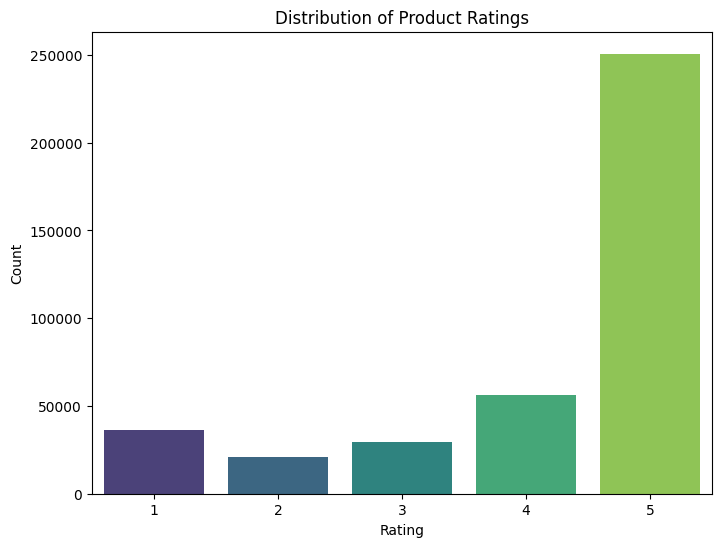

In [6]:
# Step 5: Exploratory Data Analysis (EDA)
# Distribution of Ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='Score', data=df, palette='viridis')
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

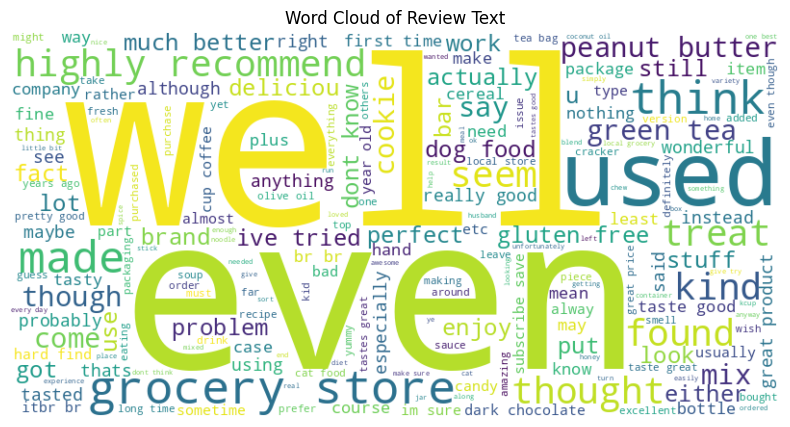

In [7]:
# Word Cloud for Most Frequent Words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['Text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Review Text')
plt.show()

In [8]:
# Step 6: Sentiment Analysis
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'Positive'
    elif analysis.sentiment.polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['Text'].apply(get_sentiment)

<function matplotlib.pyplot.show(close=None, block=None)>

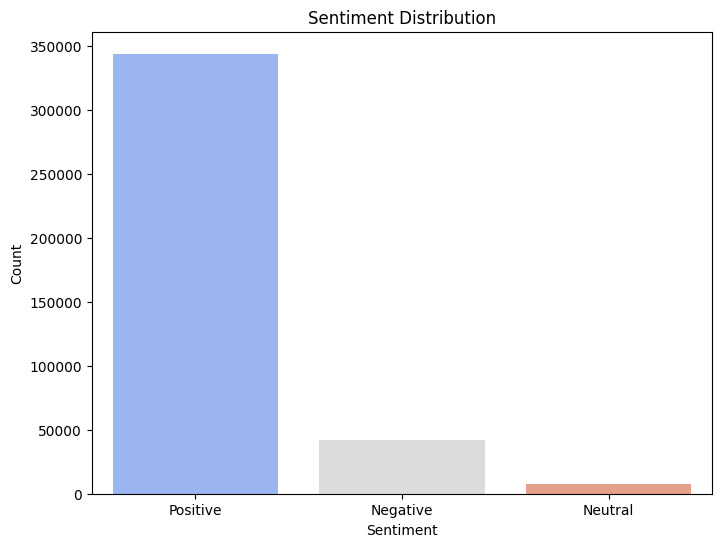

In [9]:
# Visualize Sentiment Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=df, palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show

In [10]:
# Step 7: Topic Modeling (Identify Key Complaints and Feature Requests)
# Filter negative reviews for topic modeling
negative_reviews = df[df['Sentiment'] == 'Negative']

# Use TF-IDF for text vectorization
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf.fit_transform(negative_reviews['Text'])

# Apply Latent Dirichlet Allocation (LDA)
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_matrix)

# Display Topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
print("Top Topics in Negative Reviews:")
display_topics(lda, tfidf.get_feature_names_out(), no_top_words)

Top Topics in Negative Reviews:
Topic 0:
trap traps dirty br moths set chicken caught squirrels flies
Topic 1:
box product order received ordered amazon arrived broken disappointed item
Topic 2:
like taste coffee tea flavor br bad product dont tastes
Topic 3:
dog food dogs treats cat loves cats chicken eat like
Topic 4:
price product buy store amazon br expensive local grocery like


In [11]:
# Step 8: Business Recommendations
print("\nBusiness Recommendations:")
print("1. Improve product quality to address complaints about 'taste' and 'texture'.")
print("2. Offer better packaging to reduce issues with 'damage during delivery'.")
print("3. Introduce new flavors or variants based on feature requests.")
print("4. Enhance customer service to handle complaints more effectively.")
print("5. Focus on marketing strategies to highlight positive aspects of the product.")


Business Recommendations:
1. Improve product quality to address complaints about 'taste' and 'texture'.
2. Offer better packaging to reduce issues with 'damage during delivery'.
3. Introduce new flavors or variants based on feature requests.
4. Enhance customer service to handle complaints more effectively.
5. Focus on marketing strategies to highlight positive aspects of the product.


In [12]:
# Step 9: Impact Analysis
print("\nImpact Analysis:")
print("- Preventing failed product launches by addressing key complaints.")
print("- Increasing customer satisfaction and loyalty.")
print("- Boosting sales through data-driven product adjustments.")
print("- Reducing return rates and negative reviews.")



Impact Analysis:
- Preventing failed product launches by addressing key complaints.
- Increasing customer satisfaction and loyalty.
- Boosting sales through data-driven product adjustments.
- Reducing return rates and negative reviews.


In [13]:
# Step 10: Save Results
df.to_csv('analyzed_reviews.csv', index=False)
print("\nResults saved to 'analyzed_reviews.csv'!")


Results saved to 'analyzed_reviews.csv'!
